<a href="https://colab.research.google.com/github/giuliovv/ANNDL_competitions/blob/master/notebooks/mpc_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import os 
branch = "daffy" #@param ['master', 'daffy']
if branch == "daffy":
  !pip install duckietown-gym-daffy
else:
  if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
    !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
    !pip3 install -e gym-duckietown
  if "/gym-duckietown" not in os.getcwd():
    os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay

from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

!apt update && apt install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install stable-baselines3[extra]

## imports for the ObsWrapper
import cv2
import gym
from gym.spaces import Box

import gym_duckietown

from gym_duckietown.simulator import Simulator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Releas

In [150]:
# Hyperparameters
test_results = True
T = 15
N = 10
n_from_index = 0 # How distant the first point is
frame_rate = 30
n_samples = 500

In [151]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
    frame_rate=frame_rate
)

In [152]:
plt.rcParams['figure.figsize'] = [7, 7]

In [153]:
import matplotlib.pyplot as plt
import numpy as np

!pip install casadi
from casadi import * # bad practice but hey

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [155]:
# Force a nice starting point
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [156]:
# Sampling time
dt = 1.0 / env.frame_rate

### Utils
No need to read

In [157]:
from scipy.interpolate import UnivariateSpline
from dataclasses import dataclass


@dataclass
class Position:
    x: float = 0
    y: float = 0
    theta: float = 0

    def __add__(self, other):
        x1, y1, theta1 = self.x, self.y, self.theta
        x2, y2, theta2 = other.x, other.y, other.theta
        return Position(x1+x2, y1+y2, (theta1+theta2)%360)

    def from_friendly(self, p_string: str):
        """
        Read geometry.SE2.friendly
        """
        self.theta = float(p_string.split("Pose(Rot(")[1].split("deg)")[0])
        self.x = float(p_string.split("[")[1].replace("  ", " ").split(" ")[0])
        self.y = float(p_string.split("[")[1].replace("  ", " ").split(" ")[1].replace("])", ""))
        return

def get_top_view(env):
    """
    Top down has black borders, cut them and return only the track.
    :param env: the environment
    """
    img = env.render(mode="top_down")
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,21,255,cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = img[y:y+h,x:x+w]
    return crop

def sort_xy(x, y, return_origin=False):
    """
    Sort by angle
    :param return_origin: If true returns also the computed origin
    """

    x0 = np.mean(x)
    y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    mask = np.argsort(angles)

    x_sorted = x[mask]
    y_sorted = y[mask]

    if return_origin:
        return x_sorted, y_sorted, x0, y0

    return x_sorted, y_sorted

def get_top_view_shape(env):
    env.reset()
    top_view = get_top_view(env)
    return top_view.shape

def image_to_tile_coordinates(x, y, env):
    """
    Convert image coordinates to tile coordinates.
    :param x: x coordinates
    :param y: y coordinates
    :param env: the environment
    
    :return: x, y
    """
    top_x, top_y, z = get_top_view_shape(env)

    x = x*env.grid_width*env.road_tile_size/top_y
    y = y*env.grid_height*env.road_tile_size/top_x
    return x, y

def get_angles(x, y, x0=None, y0=None):
    """
    Get the angles of the trajectory.
    
    :param x: x coordinates
    :param y: y coordinates
    :param x0: x coordinate of the origin
    :param y0: y coordinate of the origin
    """

    if x0 is None:
        x0 = np.mean(x)
    if y0 is None:
        y0 = np.mean(y)

    r = np.sqrt((x-x0)**2 + (y-y0)**2)

    angles = np.where((y-y0) > 0, np.arccos((x-x0)/r), 2*np.pi-np.arccos((x-x0)/r))

    return angles

def get_interpolation(env, no_preprocessing=False, return_origin=False, scaled=True, method="distance"):
    """
    Get the interpolation function of the trajectory of the agent in the environment.
    :param no_preprocessing: if True, the trajectory is not preprocessed
    :param return_origin: if True, the origin is returned
    :param scaled: if True, the coordinates are scaled
    :param method: if "angle", the angles are used, if "distance", the distance from starting point is used
    :return: np.array
    """
    env.reset()
    top_view = np.flip(get_top_view(env), [0])
    # top_view = get_top_view(env)

    img_hsv = cv2.cvtColor(top_view, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(top_view, cv2.COLOR_RGB2GRAY)

    lower_yellow = np.array([20,100,150])
    upper_yellow = np.array([30,255,255])

    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask = cv2.bitwise_and(gray, mask_yellow)

    if not no_preprocessing:
        kernel = np.ones((4, 4), np.uint8)
        eroded = cv2.erode(mask, kernel) 

        low_threshold = 89
        high_threshold = 80
        edges = cv2.Canny(eroded, low_threshold, high_threshold)

        rho = 1  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        threshold = 3  # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 10  # minimum number of pixels making up a line
        max_line_gap = 50  # maximum gap in pixels between connectable line segments

        lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

        _points = lines.reshape(-1, 2)

        x, y = _points.T

    else:
        x_all, y_all = np.nonzero(mask)
        x, y = x_all, y_all

    if scaled:
        x, y = image_to_tile_coordinates(x, y, env)

    x_sorted, y_sorted, x0, y0 = sort_xy(x, y, return_origin=True)


    if method == "angle":
        # Interpolation angle-based
        angles = get_angles(x_sorted, y_sorted, x0=x0, y0=y0)
        # Add first and last point
        spline_input = np.concatenate([[0], angles, [2*np.pi]])
        x_sorted = np.concatenate([[x_sorted[-1]], x_sorted, [x_sorted[0]]])
        y_sorted = np.concatenate([[y_sorted[-1]], y_sorted, [y_sorted[0]]])
    elif method == "distance":
        # Interpolation distance-based
        points = np.array([x_sorted, y_sorted]).T
        distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
        spline_input = np.insert(distance, 0, 0)/distance[-1]
    else:
        raise ValueError("Unknown method, must be 'angle' or 'distance'")


    s = 0.006 if scaled else 0.01

    spline_x = UnivariateSpline(spline_input, x_sorted, k=2, s=s)
    spline_y = UnivariateSpline(spline_input, y_sorted, k=2, s=s)

    if return_origin:
        return spline_x, spline_y, x_sorted, y_sorted, x0, y0

    return [spline_x, spline_y]

def get_trajectory(env, no_preprocessing=False, samples=50, scaled=True, method="distance", last_value_distance=1):
    """
    Get some points from the trajectory of the agent in the environment.
    :param no_preprocessing: if True, the trajectory is not preprocessed
    :param samples: the number of samples to take
    :param scaled: if True, the trajectory is scaled to the environment size
    :param method: if "angle", the angles are used, if "distance", the distance from starting point is used
    :param last_value_distance: if method is "distance", the last value is the scaled distance from the starting point
    :return: np.array
    """
    splines = get_interpolation(env, no_preprocessing=no_preprocessing, scaled=scaled, method=method)

    # Computed the spline for the asked distances:
    if method == "angle":
        alpha = np.linspace(0, 2*np.pi, samples)
    elif method == "distance":
        alpha = np.linspace(0, last_value_distance, samples)
    else:
        raise ValueError("Unknown method, must be 'angle' or 'distance'")
    points_fitted = np.vstack( spl(alpha) for spl in splines ).T

    return points_fitted

def get_position(env) -> Position:
    """
    Get the position of the agent in the environment.
    """
    p_se_matrix = env.cartesian_from_weird(env.cur_pos, env.cur_angle)
    # p_string = geometry.SE2.friendly(p_se_matrix)
    p = Position(x=p_se_matrix[0, 2], y=p_se_matrix[1, 2], theta=env.cur_angle)
    # p.from_friendly(p_string)
    return p

def show_on_map_array(env, poses, top_view=None, fig=plt):
    """
    Show the pose on the map.
    :param env: the environment
    :param pose: list of points [[x0, y0], [x1, y1], ...]
    :param top_view: the top view image, if None, it is computed
    :param fig: the figure to plot on
    """
    if top_view == None:
        top_view = get_top_view(env)
    fig.plot(poses[:, 0]*top_view.shape[1]/(env.grid_width*env.road_tile_size), poses[:, 1]*top_view.shape[0]/(env.grid_height*env.road_tile_size), c='r')
    fig.imshow(top_view, origin='lower')

def show_on_map(env, poses: Position, fig=plt):
    """
    Show the pose on the map.
    :param env: the environment
    :param pose: list of points of type Position
    :param fig: the figure to plot on
    """
    env.reset()
    top_view = get_top_view(env)
    fig.plot([p.x*top_view.shape[1]/(env.grid_width*env.road_tile_size) for p in poses], [p.y*top_view.shape[0]/(env.grid_height*env.road_tile_size) for p in poses], c='r')
    fig.imshow(top_view, origin='lower')

## Trajectory extraction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:200: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


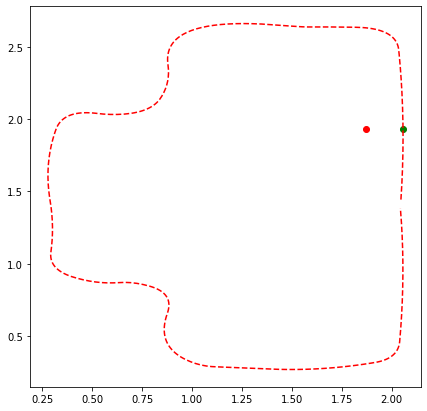

In [158]:
traj = get_trajectory(env, samples=n_samples, method="distance", last_value_distance=1)
pose = get_position(env)
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")

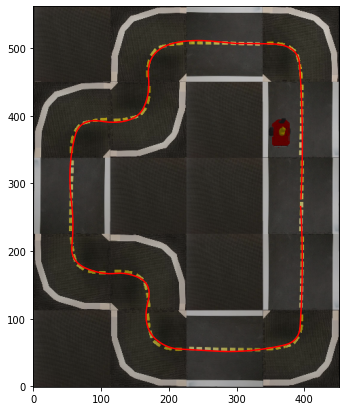

In [159]:
show_on_map_array(env, traj[:,:2])

In [160]:
get_position(env)

Position(x=1.8719999027252197, y=1.9297064071170351, theta=1.5707963267948966)

In [161]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [162]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

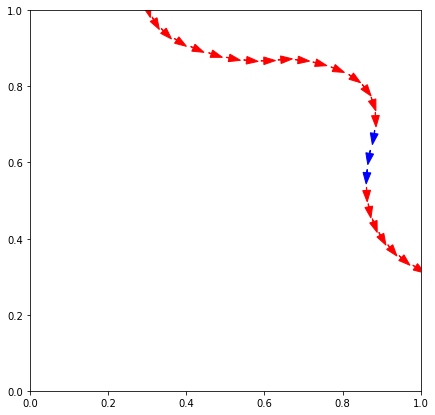

In [163]:
c="r"
for x, y, t in traj[::3]:
    dx = 0.007*np.cos(t)
    if x+dx < x:
        c = "b"
    else:
        c = "r"
    plt.arrow(x, y, dx, 0.008*np.sin(t), color=c, head_width=0.02)

In [164]:
index = DM(index)
traj = DM(traj)

## Car model

In [165]:
up = 5
wp = 4
# parameters for forced dynamics
u_alpha_r = 1.5
u_alpha_l = 1.5
w_alpha_r = 15  # modify this for trim
w_alpha_l = 15

# States
x0 = MX.sym('x')
y0 = MX.sym('y')
th0 = MX.sym('th')
v0 = MX.sym('v')
w0 = MX.sym('w')
x = vertcat(x0, y0, th0, v0, w0) # Always vertically concatenate the states --> [n_x,1]
# Inputs
wl = MX.sym('wl')
wr = MX.sym('wr')
u = vertcat(wl, wr) # Always vertically concatenate the inputs --> [n_u,1]
# System dynamics (CAN BE NONLINEAR! ;))
# x_long_dot_dot = -u1*v0 + u_alpha_r*wr + u_alpha_l*wl
# w_dot_dot = -w1*w0 + w_alpha_r*wr - w_alpha_l*wl
v1 = (1-up*dt)*v0 + u_alpha_r*dt*wr + u_alpha_l*dt*wl
w1 = (1-wp*dt)*w0 + w_alpha_r*dt*wr - w_alpha_l*dt*wl
x1 = x0 + v0*dt*np.cos(th0 + w0*dt/2)
y1 = y0 + v0*dt*np.sin(th0 + w0*dt/2)
# Cannot use atan2 because x1 and y1 are approximated while th1 is not
theta1 = th0 + w0*dt
dae = vertcat(x1, y1, theta1, v1, w1)
F = Function('F',[x,u],[dae],['x','u'],['dae'])
if test_results:
    print(F([pose.x, pose.y, pose.theta, 0, 0], [1, 1]))

[1.872, 1.92971, 1.5708, 0.1, 0]


In [166]:
pose = get_position(env)

Note that the gym env has delay!

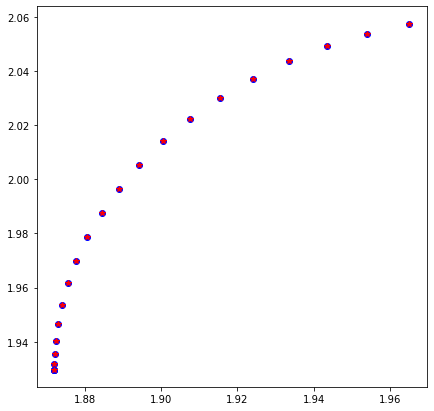

In [167]:
N_test=20
# Test the problem definition
sim = F.mapaccum(N_test) # To call the F function N times
x0 = [pose.x, pose.y, pose.theta, 0, 0]

res = sim(x0, [1, 0.2])
fig = plt.figure()
tgrid = np.linspace(0,T,N)
# plt.plot(tgrid, np.column_stack((x0, res)).T)
plt.plot(res[0, :], res[1, :], 'r*')
env.reset()
for action in [[1, 0.2]]*(N_test+3):
    obs, reward, done, info = env.step(action)
    p = get_position(env)
    plt.scatter(p.x, p.y, c='b')
_ = env.reset()

The env has delay (a non changeable parameter, not a physical constraint), this is a fair approximation of its value and we can use it in the controller

In [168]:
delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N+1)

# With preview
# Initial reference point
r0 = traj[index:index+N+1, :2].T
t0 = traj[index:index+N+1, 2].T

In [169]:
# Python % is not the same module
def mod(n, base):
    return n - floor(n/base) * base

## MPC definition

In [170]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)#-delay)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
p = opti.parameter(5,1)     # Parameter to set the initial state conditions (x(0))
r = opti.parameter(2,N+1)   # Parameter to set the initial index
tr = opti.parameter(1,N+1)   # Parameter to set the initial reference angles
u_delay = opti.parameter(2,delay) # Parameter to set the delay

Q = opti.parameter(1)
Q2 = opti.parameter(1)
Q3 = opti.parameter(1)
R = opti.parameter(1)

# With delay:
# Q, Q2, Q3, R = 100, 5e-4, 1, 1e-3
obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(mod(x[2, :]-tr+pi, 2*pi)-pi) + Q3*sumsqr(x[3, :]-0.6) + R*sumsqr(u)
# atan method is faster than mod (20s vs 23s on 1000 iterations) but it allows car to go backward
# obj = Q*sumsqr(x[:2, :]-r) + Q2*sumsqr(atan2(sin(x[2, :]-tr), cos(x[2, :]-tr))) + R*sumsqr(u)

opti.minimize(obj)          # Setup the problem 

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k in range(0,N):
   # opti.subject_to(x[:,k+1]==F(x[:,k],horzcat(u_delay, u)[:, k])) # Horzacat to include delay
   opti.subject_to(x[:,k+1]==F(x[:,k],u[:,k])) # No delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= -1)

# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == p)

opti.set_value(p,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value
opti.set_value(r,r0) # Set the initial reference points
opti.set_value(tr,t0) # Set the initial reference angles
opti.set_value(u_delay, u_delay0) # Initial delay

opti.set_value(Q, 100)
opti.set_value(Q2, 5e-4)
opti.set_value(Q3, 1)
opti.set_value(R, 1e-3)

# Ipopt (the optimizer)
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)

# Test over 1 time horizon
if test_results:
    sol = opti.solve()

In [171]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[p, r, tr, u_delay, Q, Q2, Q3, R],[u[:,0]],['p', 'r', 'tr', 'u_delay', 'Q', 'Q2', 'Q3', 'R'],['u_opt'])


## Running the MPC

In [172]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.empty((2,0))

# Original position of the car
# (x, y, theta, longitudinal speed, angular speed)
x = [pose.x, pose.y, pose.theta, 0, 0]
# First references [(x,y) ...]
r = r0
# First angular references [theta]
tr = t0

idx = index
u_delay = u_delay0
errors = []
error_x = []
error_y = []
error_theta = []

# Kdtree creates a Voronoi space: finding the closest point in the trajectory
# will be super easy
kdtree = spatial.KDTree(traj[:, :2])

for i in range(450):
    # Use the MPC to compute the optimal input to the system
    u = M(x, r, tr, u_delay, 100, 5e-4, 1, 1e-3)

    # Save input (u) and states (X)
    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    # Delay, we don't use this yet
    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    # Save distances to reference for debugging
    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2
    errors.append(distance)
    error_x.append(traj[idx, 0] - x[0])
    error_y.append(traj[idx, 1] - x[1])
    error_theta.append(mod(x[2]-traj[idx, 2]+pi, 2*pi)-pi)

    # Find the index idx of the closest point in the trajectory 
    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    try:
        # Compute next reference (x,y) given idx
        r = traj[idx:idx+N+1, :2].T
        # Same as before but for the angle reference
        tr = traj[idx:idx+N+1, 2].T
    except Exception:
        break

In [173]:
f"Max reached speed: {X_log[3,:].max()}, max speed is 0.6"

'Max reached speed: 0.5821272989575572, max speed is 0.6'

Text(0.5, 1.0, 'Car in the circuit')

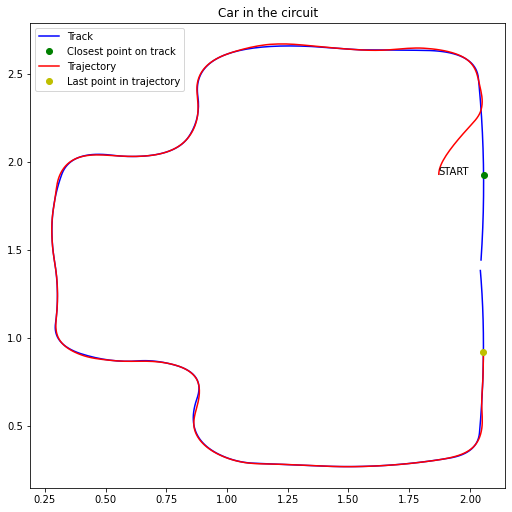

In [174]:
fig = plt.figure(constrained_layout=True, figsize=(7, 7))
plt.text(X_log[0,0], X_log[1,0], 'START')
plt.plot(traj[:,0], traj[:,1], "b", label="Track")
plt.plot(traj[index,0], traj[index,1], 'go', label="Closest point on track")
plt.plot(X_log[0,:], X_log[1,:], "r", label="Trajectory")
plt.plot(traj[idx, 0], traj[idx,1], 'yo', label="Last point in trajectory")
plt.legend()
plt.title("Car in the circuit")

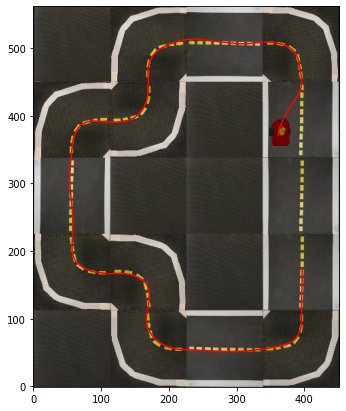

In [175]:
show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T)

## Simulate in duckietown environment

Note that the environment has delay and this MPC does not consider the delay yet

In [176]:
record = False

if record:
    import imageio
    import cv2

    env.reset()
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)
        positions.append(get_position(env))
    ! mkdir ./assets
    imageio.mimsave("./assets/mpc_run.gif", images, format='GIF', fps=env.frame_rate)

In [177]:
if record:
  show_on_map(env, positions)

In [178]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="./assets/mpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))

## Example with relative reference

Let's assume the same initial point as before, but this example will be relative to the car so we will not actually know the position of the car wrt to the map (during the competition we will not know the map either)

In [179]:
initial_position = (X_log[0,0], X_log[1,0], X_log[2,0])

Text(1.8719999027252197, 1.9297064071170351, '  <- We are here')

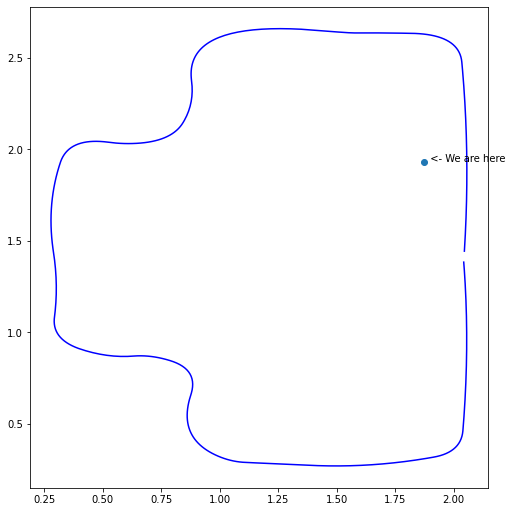

In [180]:
fig = plt.figure(constrained_layout=True, figsize=(7, 7))
plt.scatter(X_log[0,0], X_log[1,0])
plt.plot(traj[:,0], traj[:,1], "b")
plt.text(X_log[0,0], X_log[1,0], '  <- We are here')

In [184]:
# MPC loop
X_log = np.empty((5,0))
U_log = np.empty((2,0))

# This time we consider the origin in the car, so the first position of the car
# will be (x, y, theta, longitudinal speed, angular speed) = (0,0,?,0,0)
# Angle is critical wrt the map so we simplify by starting with the right heading
x = [0, 0, initial_position[2], 0, 0]
# Let's go to (0.1, 0.1)
r = np.repeat([[0.2,0.2]], N+1, axis=0).T
# Angular reference at 0 and weight of angle at 0 so we don't care about the angle
# (See below)
tr = np.zeros((1, N+1))
idx = index

distance = 100

# How close to the final point the car should be to stop
min_distance_ref = 0.01

while distance > min_distance_ref:
    # Second param is minimize error wrt angle
    # Third param is maximize speed
    u = M(x, r, tr, u_delay, 100, 0, 0, 1e-3)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    # simulate
    x = F(x,u)

    distance = np.sqrt((x[0]-r[0,0])**2+(x[1]-r[1,0])**2)

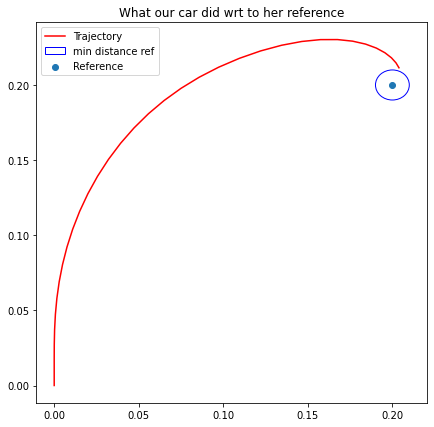

In [185]:
plt.plot(X_log[0,:], X_log[1,:], "r", label="Trajectory")
plt.scatter(r[0,0], r[1,0], label="Reference")
crc = plt.Circle((r[0,0], r[1,0]), min_distance_ref, color='b', fill=False, label="min distance ref")
ax = plt.gca()
ax.add_patch(crc)
plt.title("What our car did wrt to her reference")
plt.legend()

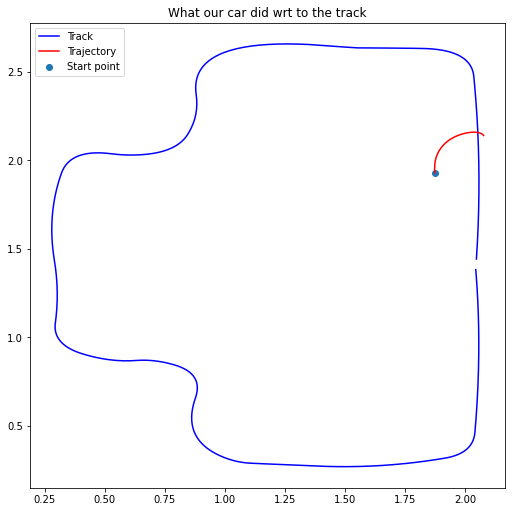

In [186]:
fig = plt.figure(constrained_layout=True, figsize=(7, 7))
plt.scatter(X_log[0,0]+initial_position[0], X_log[1,0]+initial_position[1], label="Start point")
plt.plot(traj[:,0], traj[:,1], "b", label="Track")
plt.plot(X_log[0,:]+initial_position[0], X_log[1,:]+initial_position[1], "r", label="Trajectory")
plt.title("What our car did wrt to the track")
plt.legend()

The reference is pretty far, that is why it does not go straight to the final point